## Set Up Environment and Upload Data

In [1]:
import pandas as pd 
import numpy as np
from matplotlib.pyplot import figure
from os import listdir
from os.path import isfile, join
import re
from scipy.stats import zscore
from scipy.spatial import distance_matrix

pd.set_option('display.max_columns', None)

path = 'C:\\Users\\steve\\OneDrive\\Desktop\\Github\\NFL Big Data Bowl\\0. Data'
allFiles = [f for f in listdir(path) if isfile(join(path, f))]

In [3]:
# Upload files
games = pd.read_csv("../0. Data/games.csv")
players = pd.read_csv("../0. Data/players.csv")
plays = pd.read_csv("../0. Data/plays.csv")

fbf_df = pd.DataFrame()

# Go through all weekly data and upload it
for file in allFiles:
    if "week" in file:
        temp_week = pd.read_csv("../0. Data/"+file)
        temp_week['week'] = re.findall(r'\d+', file)[0]
        fbf_df = pd.concat([fbf_df, temp_week])

# merge with games to add home/away team indicators
fbf_df = fbf_df.merge(games[['gameId','homeTeamAbbr','visitorTeamAbbr']], on='gameId')
players['short_name'] = players.displayName.str.split(" ").str[0].str[0].str.strip()+"."+\
players.displayName.str.split(" ").str[1].str.strip()

## Add Receiver Tier

In [21]:
# Record who is being targetted on each play and format them
plays['target'] = plays.playDescription.str.split(" to ").str[1].str.split(" ").str[0]
plays['target'] = np.where(plays['target'].str.strip().str[-1]==".", 
                           plays['target'].str.strip().str[:-1], plays['target'])

completed_plays = plays[plays.passResult == 'C']
reception_leaders = completed_plays.target.value_counts().reset_index()

array([[<AxesSubplot:title={'center':'target'}>]], dtype=object)

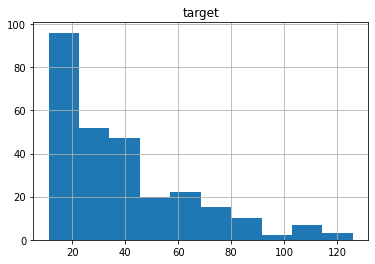

In [22]:
reception_leaders[reception_leaders.target>10].hist()

In [23]:
reception_leaders["WR Tier"] = np.where(reception_leaders.target > np.quantile(reception_leaders[reception_leaders.target>10].target, 0.5),
                                        "WR3", "WR4" )

reception_leaders["WR Tier"] = np.where(reception_leaders.target > np.quantile(reception_leaders[reception_leaders.target>10].target, 0.75),
                                        "WR2", reception_leaders["WR Tier"]  )


reception_leaders["WR Tier"] = np.where(reception_leaders.target > np.quantile(reception_leaders[reception_leaders.target>10].target, 0.9),
                                        "WR1", reception_leaders["WR Tier"])
reception_leaders.rename({'target':'receptions'}, axis=1, inplace=True)
reception_leaders.rename({'index':'target'}, axis=1, inplace=True)

plays = pd.merge(plays, reception_leaders[['target','WR Tier']], on='target', how='left')

## Filter Plays

In [24]:


# filter on pass play only without DPI
filtered_plays = plays[plays['playType']=='play_type_pass']
filtered_plays = filtered_plays[~filtered_plays['target'].isna()]
filtered_plays = filtered_plays[filtered_plays['isDefensivePI']==False]

# Retain only two events - snap and throw
fbf_df = fbf_df[fbf_df['event'].isin(['ball_snap', 'pass_forward'])]
fbf_df = fbf_df.merge(filtered_plays[['possessionTeam',
                                      'gameId',
                                      'playId',
                                      'target',
                                      'personnelO',
                                      'defendersInTheBox',
                                      'numberOfPassRushers',
                                      'personnelD',
                                      'typeDropback',
                                      'down',
                                      'yardsToGo',
                                      'WR Tier'
                                     ]], 
                      on=['gameId','playId'], how='inner')

# Identify team in possession
fbf_df['team2'] = np.where(fbf_df['team']=='home',fbf_df['homeTeamAbbr'],
                                 fbf_df['visitorTeamAbbr'])
fbf_df["inPoss"] = np.where(fbf_df['possessionTeam']==fbf_df['team2'],1,0)
fbf_df = pd.merge(fbf_df, players[['position','displayName','short_name']], on=['position','displayName'], how='inner')
fbf_df["targetted"] = np.where(fbf_df["short_name"]==fbf_df["target"],1,0)

# Some players aren't properly matched by our created target, remove the play from analysis
retain = fbf_df.groupby(['gameId','playId','frameId']).sum(['targetted']).reset_index()
retain_plays = retain[retain.targetted==1].playId.unique()
fbf_df = fbf_df[fbf_df.playId.isin(retain_plays)]

# some plays only have offense and not defense, remove from analysis
exclude = fbf_df.groupby(['gameId','playId','frameId','inPoss']).size().reset_index()
exclude = exclude.groupby(['gameId','playId','frameId']).size().reset_index()
exclude = exclude[exclude[0]!=2]
fbf_df = fbf_df.merge(exclude[['gameId','playId','frameId']], on=['gameId','playId','frameId'], 
                      how='outer', indicator=True)
fbf_df = fbf_df[fbf_df._merge!="both"]

## Distance to QB

In [25]:
qb_fbf_df = fbf_df[fbf_df.position=="QB"][['x', 'y', 's', 'a', 'dis', 'o', 'dir'
                                           , 'frameId', 'gameId', 'playId']]

qb_fbf_df.columns = ['qb_x', 'qb_y', 'qb_s', 'qb_a', 'qb_dis', 'qb_o', 'qb_dir'
                                           , 'frameId', 'gameId', 'playId']

fbf_df = pd.merge(fbf_df, qb_fbf_df, on=['frameId', 'gameId', 'playId'])

fbf_df['delta_x'] = fbf_df['x'] - fbf_df['qb_x']
fbf_df['delta_y'] = fbf_df['y'] - fbf_df['qb_y']
fbf_df['delta_s'] = fbf_df['s'] - fbf_df['qb_s']
fbf_df['delta_a'] = fbf_df['a'] - fbf_df['qb_a']
fbf_df['delta_dis'] = fbf_df['dis'] - fbf_df['qb_dis']
fbf_df['delta_o'] = fbf_df['o'] - fbf_df['qb_o']
fbf_df['delta_dir'] = fbf_df['dir'] - fbf_df['qb_dir']

## Find Closest Defender

In [26]:
temp=[]
for g, grouped_df in fbf_df.groupby(['gameId', 'playId', 'frameId']):
#     print(g)

    # Isolate the wide receivers
    df_wr = grouped_df[(grouped_df["inPoss"]==1)]

    if not df_wr.empty:
        # Isolate the defenders
        df_d =  grouped_df[grouped_df["inPoss"]==0]
        # Calculate the distance matrix between each WR and defenders
        dm = distance_matrix(df_wr[['x','y']].values, 
                 df_d[['x','y']].values)
        

        # use argmin and min to record the closest defender, and their distance
        closest_defender = dm.argmin(axis=1)
        closest_defender_distance = dm.min(axis=1)

        # Create a dataframe to record  the information
        for i,j in enumerate(closest_defender):
            temp_df = pd.DataFrame({
                'gameId':[g[0]]
                ,'playId':[g[1]]
                ,'frameId':[g[2]]
                ,'displayName':[df_wr.displayName.iloc[i]]
                ,'closestDefender':[df_d.displayName.iloc[j]]
                ,'closestDefenderDistance':[closest_defender_distance[i]]
            })

            temp.append(temp_df)
            
distance_df = pd.concat(temp)

## Create Final Dataframes

In [27]:
fbf_df = fbf_df.merge(distance_df, on=['gameId','playId','frameId','displayName'], how='inner')
fbf_df = fbf_df[fbf_df.inPoss==1]
fbf_df = fbf_df[fbf_df['position'].isin(['WR','TE','RB','HB','FB'])]

In [35]:
cols = ['displayName','delta_x', 'delta_y', 'delta_s', 'delta_a', 'delta_dis', 'delta_o', 'delta_dir', 
       'position', 'frameId', 'gameId',
       'playId', 'route',
       'personnelO',
       'defendersInTheBox', 'numberOfPassRushers', 'personnelD',
       'typeDropback', 'targetted',
       'closestDefenderDistance','down', 'yardsToGo','WR Tier']

snap_df = fbf_df[fbf_df.event=="ball_snap"][cols]
pass_df = fbf_df[fbf_df.event=="pass_forward"][cols]

In [36]:
snap_df.shape

(83409, 24)

In [40]:
snap_df.targetted.sum()/snap_df.shape[0]

0.19312064645302066

In [37]:
pass_df.shape

(82308, 24)

In [38]:
snap_df

,displayName,delta_x,delta_y,delta_s,delta_a,delta_dis,delta_o,delta_dir,position,frameId,gameId,playId,playDirection,route,personnelO,defendersInTheBox,numberOfPassRushers,personnelD,typeDropback,targetted,closestDefenderDistance,down,yardsToGo,WR Tier
1,Julio Jones,-0.38,17.47,0.00,0.01,0.01,12.12,-185.15,WR,11,2018090600,75,left,HITCH,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,1,7.472858,1,15,WR1
2,Mohamed Sanu,-0.96,9.49,0.00,0.00,-0.01,-18.22,59.92,WR,11,2018090600,75,left,HITCH,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,1.920339,1,15,WR1
3,Devonta Freeman,6.51,-0.05,0.00,0.00,-0.01,-17.46,-41.82,RB,11,2018090600,75,left,NaN,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,12.460915,1,15,WR1
4,Austin Hooper,-0.44,-4.82,0.00,0.01,-0.01,-26.56,-90.10,TE,11,2018090600,75,left,OUT,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,4.833353,1,15,WR1
5,Ricky Ortiz,3.38,0.03,0.00,0.00,0.00,-30.31,0.19,FB,11,2018090600,75,left,FLAT,"2 RB, 1 TE, 2 WR",7.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,9.420133,1,15,WR1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200120,Jeff Wilson,3.08,8.57,0.70,0.84,0.06,-13.16,17.14,RB,11,2018120910,1750,right,GO,"2 RB, 1 TE, 2 WR",5.0,4.0,"4 DL, 3 LB, 4 DB",TRADITIONAL,0,8.207411,2,9,WR4
200126,Kendrick Bourne,0.66,8.54,0.02,0.57,-0.01,27.05,-42.88,WR,11,2018120910,1854,right,IN,"2 RB, 1 TE, 2 WR",7.0,5.0,"4 DL, 3 LB, 4 DB",TRADITIONAL,0,3.620124,2,3,WR4
200128,Dante Pettis,-0.27,11.05,0.00,0.07,-0.01,17.71,-4.17,WR,11,2018120910,1854,right,POST,"2 RB, 1 TE, 2 WR",7.0,5.0,"4 DL, 3 LB, 4 DB",TRADITIONAL,0,6.281059,2,3,WR4
200129,Garrett Celek,0.59,-4.54,0.20,1.93,0.01,16.38,-147.41,TE,11,2018120910,1854,right,NaN,"2 RB, 1 TE, 2 WR",7.0,5.0,"4 DL, 3 LB, 4 DB",TRADITIONAL,0,6.507296,2,3,WR4
